In [2]:
# https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

In [17]:
dataset_filename = 'D14' # Only need to use this when D14 is involved -> different filename structure, notice how you have to change the 'dataset'
dataset = "14D"
filename = f"{dataset_filename} v cntl.xlsx"
p_col_name = f'P-value ({dataset} vs Control)'
fdr_col_name = f'FDR step up ({dataset} vs Control)'
fold_change_col_name = f'Fold change ({dataset} vs Control)'

df = pd.read_excel(filename)
df.head()

,Gene ID,Gene name,P-value (14D vs Control),FDR step up (14D vs Control),Ratio (14D vs Control),Fold change (14D vs Control),LSMean(14D) (14D vs Control),LSMean(Control) (14D vs Control),Unnamed: 8,Unnamed: 9
0,0610005C13Rik,0610005C13Rik,0.783923,?,1.282563,1.282563,7.788303,6.072451,NaN,0.105727
1,0610006L08Rik,0610006L08Rik,0.371103,?,0.155003,-6.451478,0.35889,2.315373,NaN,0.430506
2,0610009B22Rik,0610009B22Rik,0.065484,0.252279,0.443589,-2.254338,28.604666,64.484591,NaN,1.183867
3,0610009E02Rik,0610009E02Rik,0.065719,?,5.739945,5.739945,9.569081,1.667103,NaN,1.182309
4,0610009L18Rik,0610009L18Rik,0.776872,0.904435,0.880335,-1.135931,19.076491,21.669576,NaN,0.109651


In [18]:
print(df.columns)
print(df[p_col_name].dtype)
df[p_col_name] = pd.to_numeric(df[p_col_name], errors='coerce')

Index(['Gene ID', 'Gene name', 'P-value (14D vs Control)',
       'FDR step up (14D vs Control)', 'Ratio (14D vs Control)',
       'Fold change (14D vs Control)', 'LSMean(14D) (14D vs Control)',
       'LSMean(Control) (14D vs Control)', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')
object


***Lets calculate a P-Adjust Value using the Benjamini-Hochberg method***

In [24]:
import scipy
print(scipy.__version__)
 
from scipy import stats

# Filter out df rows where pvalues are NaN
print(f'Number of NaN values in {p_col_name}: {df[p_col_name].isna().sum()}')
df = df.dropna(subset=[p_col_name])



pvalues = df[p_col_name].tolist()

# Ensure pvalues is a numpy array
pvalues = np.array(pvalues)

print(f'Maximum p-value: {max(pvalues)}')
print(f'Minimum p-value: {min(pvalues)}')
print(f'Length of p-values: {len(pvalues)}')

# Clip values to the range [0, 1]
pvalues = np.clip(pvalues, 0, 1)

# Check for NaN or infinite values
has_nan = np.isnan(pvalues).any()
has_inf = np.isinf(pvalues).any()
print(f'Contains NaN: {has_nan}')
print(f'Contains inf: {has_inf}')

# Remove NaN and infinite values
pvalues = pvalues[~np.isnan(pvalues)]
pvalues = pvalues[~np.isinf(pvalues)]


print(f'Maximum p-value after clipping: {max(pvalues)}')
print(f'Minimum p-value after clipping: {min(pvalues)}')
print(f'Length of p-values after clipping: {len(pvalues)}')

p_adj = stats.false_discovery_control(pvalues, method='bh')

# Append the adjusted p-values to the DataFrame
df[f'Adjusted {p_col_name}'] = p_adj

# save the DataFrame to a CSV file
df.to_csv(f'adjusted_{filename}', index=False)


# Print number of significant genes
print(f'Number of significant genes: {len(df[df[f"Adjusted {p_col_name}"] <= 0.05])}')

1.11.4
Number of NaN values in P-value (14D vs Control): 0
Maximum p-value: 0.999965350711524
Minimum p-value: 1.38002773228207e-28
Length of p-values: 29367
Contains NaN: False
Contains inf: False
Maximum p-value after clipping: 0.999965350711524
Minimum p-value after clipping: 1.38002773228207e-28
Length of p-values after clipping: 29367
Number of significant genes: 1254


**These results are different from using the raw gene counts in DESeq2 to generate p-adjust, now lets try using the native p-adjust method in R using the r2py pckg**

In [ ]:
# Once you get these results, then check the significant genes in each and see if the same ones are upregulated, because you are getting a different number of significant genes for each method so far

In [7]:
# Lets filter out the rows where the 'FDR step up (D5 vs Control)' == '?'
print('Shape of df before filtering: ', df.shape)
df = df[df[fdr_col_name] != '?']
print('Shape of df after filtering FDR step up, "?": ', df.shape)

# Now we must filter for 'FDR step up (D5 vs Control)' <= 0.05
# df = df[df['FDR step up (D5 vs Control)'] <= 0.05]
# print('Shape of df after filtering FDR step up cutoff, "<= 0.05": ', df.shape)

# Now we must filter for 'P-value (D5 vs Control)' <= 0.05
df = df[df[p_col_name] <= 0.05]
print('Shape of df after filtering P-value cutoff, "<= 0.05": ', df.shape)

# print out some statistics of the Fold Change
print('Mean: ', df[fold_change_col_name].mean())
print('Median: ', df[fold_change_col_name].median())
print('Std: ', df[fold_change_col_name].std())

Shape of df before filtering:  (17617, 11)
Shape of df after filtering FDR step up, "?":  (17617, 11)
Shape of df after filtering P-value cutoff, "<= 0.05":  (3871, 11)
Mean:  0.4791148371174069
Median:  1.32770601161101
Std:  2.109849931272845


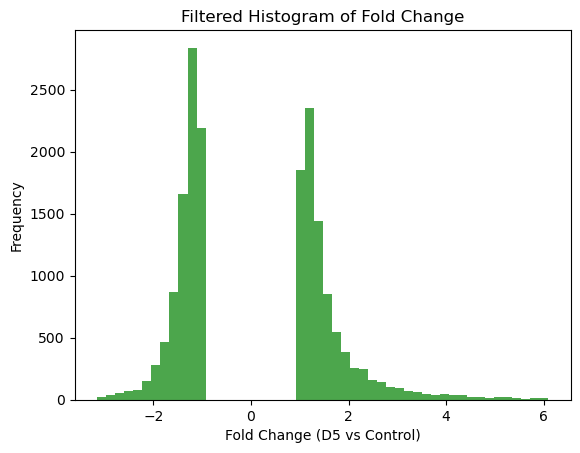

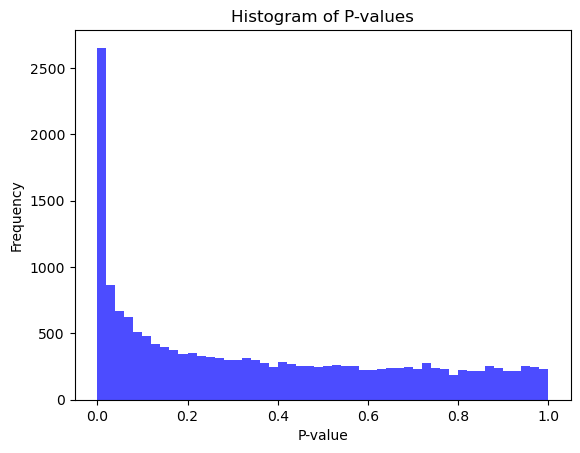

In [5]:
# Removing extreme outliers for visualization and analysis
q_low = df[fold_change_col_name].quantile(0.01)
q_high = df[fold_change_col_name].quantile(0.99)

df = df[(df[fold_change_col_name] > q_low) & (df[fold_change_col_name] < q_high)]

# Replot histogram with filtered data
plt.hist(df[fold_change_col_name], bins=50, color='green', alpha=0.7)
plt.title('Filtered Histogram of Fold Change')
plt.xlabel('Fold Change (D5 vs Control)')
plt.ylabel('Frequency')
plt.show()


# Plot the histogram of p-values
plt.hist(df[p_col_name], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of P-values')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

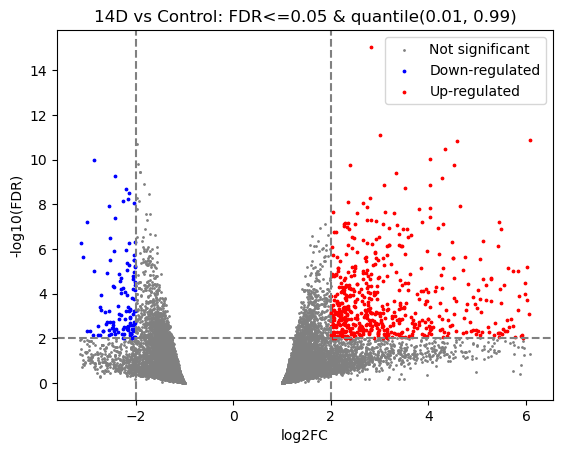

In [ ]:
# # Handling non-numeric and zero values before applying log2
df[fold_change_col_name] = pd.to_numeric(df[fold_change_col_name], errors='coerce').replace(0, np.nan)

# Applying log2 transformation
df['logFC'] = df[fold_change_col_name]

# Plot non-significant points
plt.scatter(
    x=df['logFC'],
    y=df[p_col_name].apply(lambda x: -np.log10(x)),
    s=1,
    label="Not significant",
    color='grey'
)

# Highlight down- or up-regulated genes
down = df[(df['logFC'] <= -2) & (df[p_col_name] <= 0.01)]
up = df[(df['logFC'] >= 2) & (df[p_col_name] <= 0.01)]

plt.scatter(
    x=down['logFC'],
    y=down[p_col_name].apply(lambda x: -np.log10(x)),
    s=3,
    label="Down-regulated",
    color="blue"
)
plt.scatter(
    x=up['logFC'],
    y=up[p_col_name].apply(lambda x: -np.log10(x)),
    s=3,
    label="Up-regulated",
    color="red"
)

# Axes and labels
plt.title(f"{dataset} vs Control: FDR<=0.05 & quantile(0.01, 0.99)")
plt.xlabel("log2FC")
plt.ylabel("-log10(FDR)")
plt.axvline(x=-2, color="grey", linestyle="--")
plt.axvline(x=2, color="grey", linestyle="--")
plt.axhline(y=2, color="grey", linestyle="--")  # Threshold for significance; adjust if different

# Legend and plot display
plt.legend()
plt.show()

**Now we go backwards and work with Normalized Gene Counts of mRNA transcripts to make violin plots and heatmaps**

In [ ]:
from deg_utils import *
deg_filename = 'mRNA_gene.FPKM.csv'
df = read_mrna_gene_expression_files(deg_filename)
df_avg = compute_transcript_avg_counts_conditions(deg_filename)

In [114]:
def load_gene_list(filename):
    with open(filename, 'r') as file:
        gene_list = file.read().strip().splitlines()
        print(f'\n\nGene List: {gene_list}\n\n')
    return gene_list

def filter_data_by_genes(df_avg, gene_list):
    # Assuming 'Gene Name' is the column in `df` that contains the gene identifiers
    # Filter the DataFrame based on the gene list, making it not case sensitive
    df_avg['Gene Name'] = df_avg['Gene Name'].str.upper()
    gene_list = [gene.upper() for gene in gene_list]
    df_avg = df_avg[df_avg['Gene Name'].isin(gene_list)]
    
    print(f'\n\nFiltered Data by Gene DF:\n\n{df_avg}\n\n')

    return df_avg

def reshape_violin_df(df):

    # This function will just transpose the dataframe and then delete any misc columns
    # The end result is a dataframe with gene names on the top, and then the rows are the different samples, they are NOT AVERAGED

    # Delete the following columns: gene_id, gene_description, gene_locus
    df = df.drop(['gene_id', 'gene_description', 'gene_locus'], axis=1)
    # Transpose the DataFrame
    df = df.T
    print(f'\n\nTranspose DataFrame Head:\n\n{df.head()}\n\n')
    
    # Reset the index
    df = df.reset_index()
    print(f'\n\nReset Index DataFrame Head:\n\n{df.head()}\n\n')

    # Get the conditions, this is for plotting violins for single genes
    conditions_t = df.iloc[:, 0]
    conditions_list = conditions_t.tolist()
    conditions = conditions_list[1:]
    
    # Delete the first column
    df = df.drop(df.columns[0], axis=1)
    # Drop the header and make the first row the column names
    df.columns = df.iloc[0]
    # Drop the first row
    df = df.iloc[1:]
    print(f'\n\nReshaped ViolinDataFrame Head:\n\n{df.head()}\n\n')
    print(f'\n\nReshaped ViolinDataFrame Shape:\n\n{df.shape}\n\n')
    
    return df, conditions

def plot_violin(df):
    # This is for plotting all genes of interest and combining the conditions into a violin

    # Melting the DataFrame so each row is a condition-gene pair with an expression value
    melted_df = df.melt(var_name='Gene', value_name='Expression')
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Gene', y='Expression', data=melted_df, palette='muted', scale='width')
    plt.title('Gene Expression Levels by Gene')
    plt.xlabel('Gene')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=90)  # Rotate x labels for better readability, as you might have many genes
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

def prepare_df_for_gene_violin(df, gene):
    """
    Prepare DataFrame for violin plot by restructuring it into long format
    """
    # Drop unnecessary columns
    df = df.drop(['gene_id', 'gene_description', 'gene_locus'], axis=1)
    
    # Filter the DataFrame for the specified gene
    df = df[df['Gene Name'] == gene]
    
    # Transpose the DataFrame so that samples are rows
    df = df.set_index('Gene Name').T.reset_index()
    
    # Rename columns for clarity
    df.columns = ['Sample', 'Expression']
    
    # Extract condition from the sample names
    df['Condition'] = df['Sample'].apply(lambda x: x.split('_')[0])
    
    # Ensure 'Condition' is explicitly converted to strings
    df['Condition'] = df['Condition'].astype(str)
    
    # Ensure 'Expression' is numeric
    df['Expression'] = pd.to_numeric(df['Expression'], errors='coerce')
    
    return df

def plot_gene_violin(prepared_df, gene):
    """
    Create violin plot using the prepared DataFrame
    """
    # Plot the violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Condition', y='Expression', data=prepared_df, palette='muted', scale='width')
    plt.title(f'Expression Levels of {gene} by Condition')
    plt.xlabel('Condition')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_heatmap(df_avg):
    # Assuming the row index is 'Gene Name' and columns are the conditions
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_avg.set_index('Gene Name'), annot=True, cmap='viridis', cbar=True)
    plt.title('Heatmap of Gene Expression')
    plt.xlabel('Condition')
    plt.ylabel('Gene')
    plt.show()

def plot_pca(normalized_counts):
    # Perform PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(normalized_counts)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(data = pca_results, columns = ['PC1', 'PC2'])
    pca_df['sample'] = normalized_counts.index

    # Plot PCA
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='sample', data=pca_df, palette='viridis', s=100)
    plt.title('PCA Plot of Bulk RNA-seq Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


In [115]:
# Load the gene list
gene_list_filename = 'gene_list.txt'
gene_list = load_gene_list(gene_list_filename)

filtered_df = filter_data_by_genes(df, gene_list) # filtering df for Violin plot

filtered_df, conditions = reshape_violin_df(filtered_df) # reshaping df for violin-friendly input

filtered_avg_df = filter_data_by_genes(df_avg, gene_list) # filtering df_avg for Heatmap plot





Gene List: ['CREBBP', 'LRG1', 'EP300', 'RNF111', 'HIPK2']




Filtered Data by Gene DF:

                  gene_id Gene Name  \
5629   ENSMUSG00000061436     HIPK2   
9281   ENSMUSG00000032217    RNF111   
14285  ENSMUSG00000055024     EP300   
14581  ENSMUSG00000022521    CREBBP   
15759  ENSMUSG00000037095      LRG1   

                                        gene_description  \
5629   homeodomain interacting protein kinase 2 [Sour...   
9281   ring finger 111 [Source:MGI Symbol;Acc:MGI:193...   
14285  E1A binding protein p300 [Source:MGI Symbol;Ac...   
14581  CREB binding protein [Source:MGI Symbol;Acc:MG...   
15759  leucine-rich alpha-2-glycoprotein 1 [Source:MG...   

                 gene_locus   C_1_237N   C_2_281N   C_3_280N  D5_1_267N  \
5629    6:38671325-38853099   2.546413   4.695455   4.221430   4.464952   
9281    9:70332706-70411007   8.425950   9.354399  17.348850  12.827987   
14285  15:81469552-81536278  11.268221  10.239554  20.926394  18.410681   
14581    16:3

/tmp/ipykernel_1689/4203007824.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gene', y='Expression', data=melted_df, palette='muted', scale='width')
/tmp/ipykernel_1689/4203007824.py:56: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Gene', y='Expression', data=melted_df, palette='muted', scale='width')


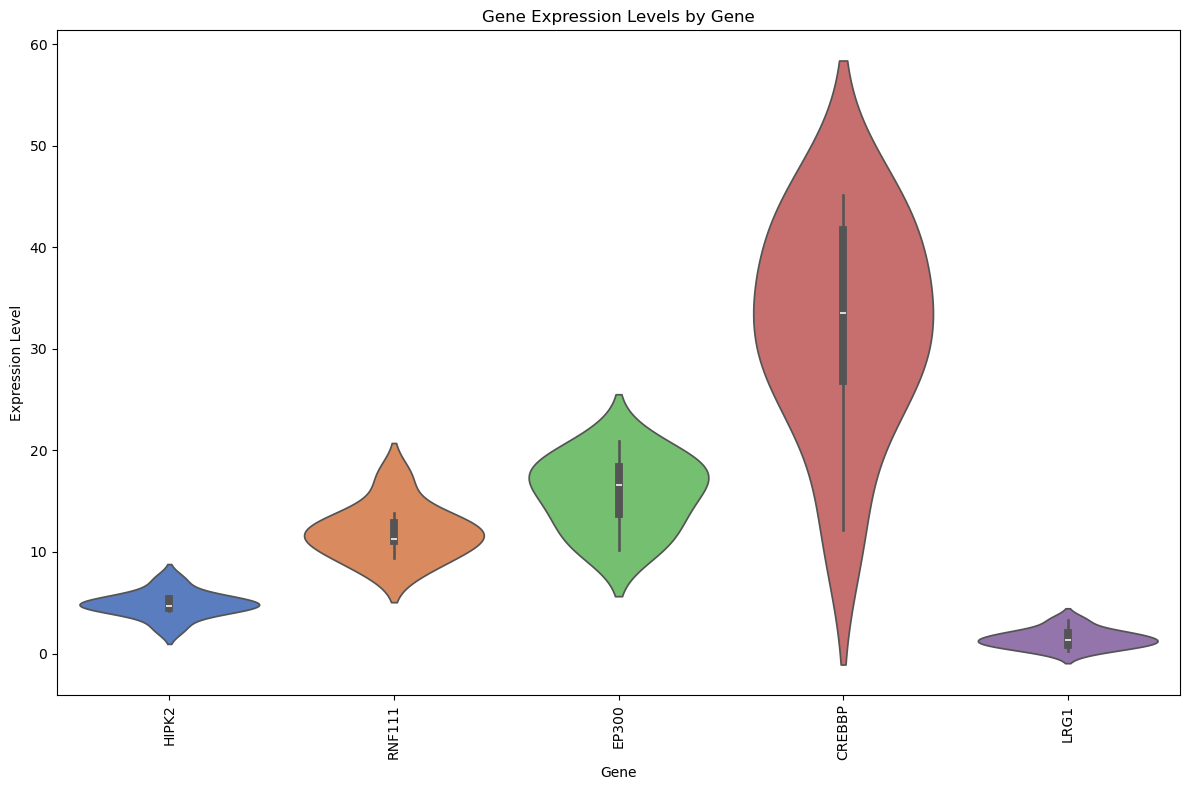

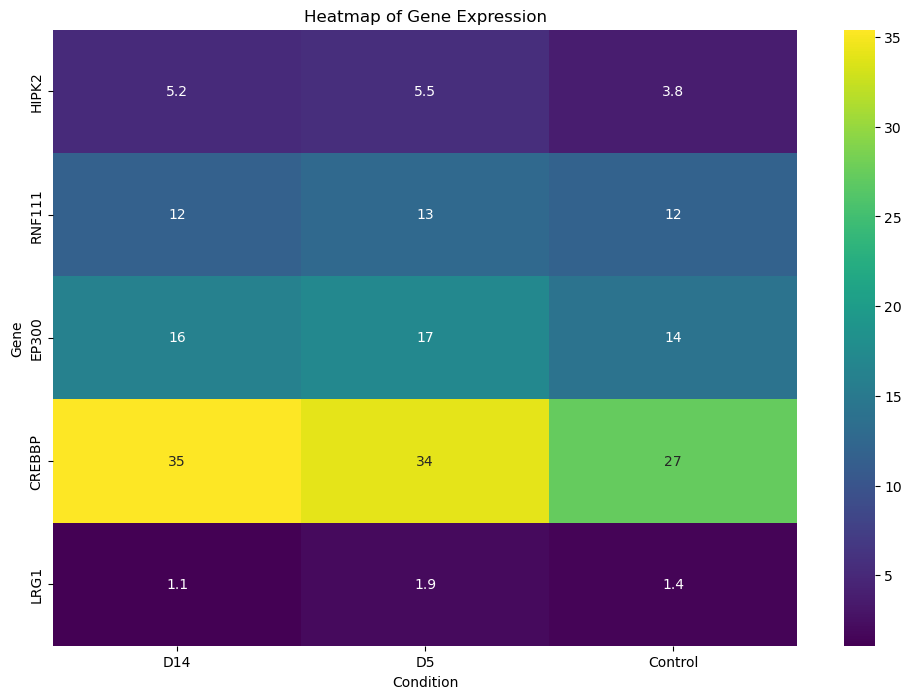

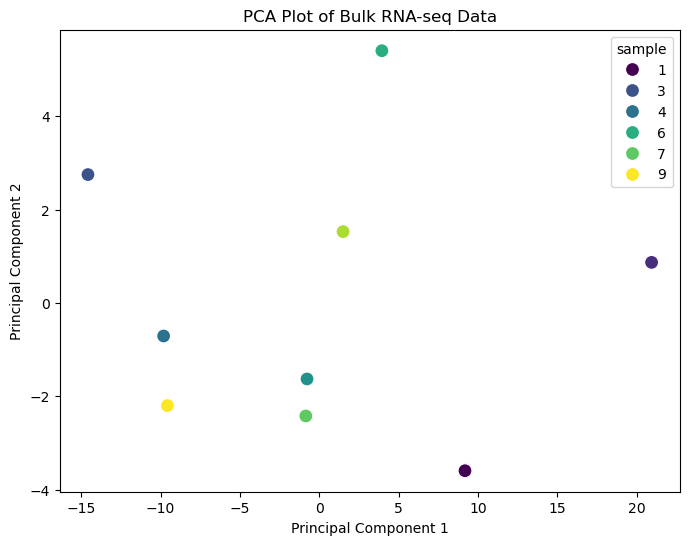

In [116]:
# Create the plots
plot_violin(filtered_df)
plot_heatmap(filtered_avg_df)
plot_pca(filtered_df)


**Now here is the Single Gene Violin Plot**

       Sample  Expression Condition
0    C_1_237N   26.955881         C
1    C_2_281N   26.168907         C
2    C_3_280N   46.103695         C
3   D5_1_267N   40.846436        D5
4   D5_2_284L   39.625774        D5
5   D5_3_284N   49.564724        D5
6  D14_1_237R   35.952656       D14
7  D14_2_238R   35.043705       D14
8  D14_3_266R   37.724064       D14


/tmp/ipykernel_1689/4203007824.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='Expression', data=prepared_df, palette='muted', scale='width')
/tmp/ipykernel_1689/4203007824.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Condition', y='Expression', data=prepared_df, palette='muted', scale='width')


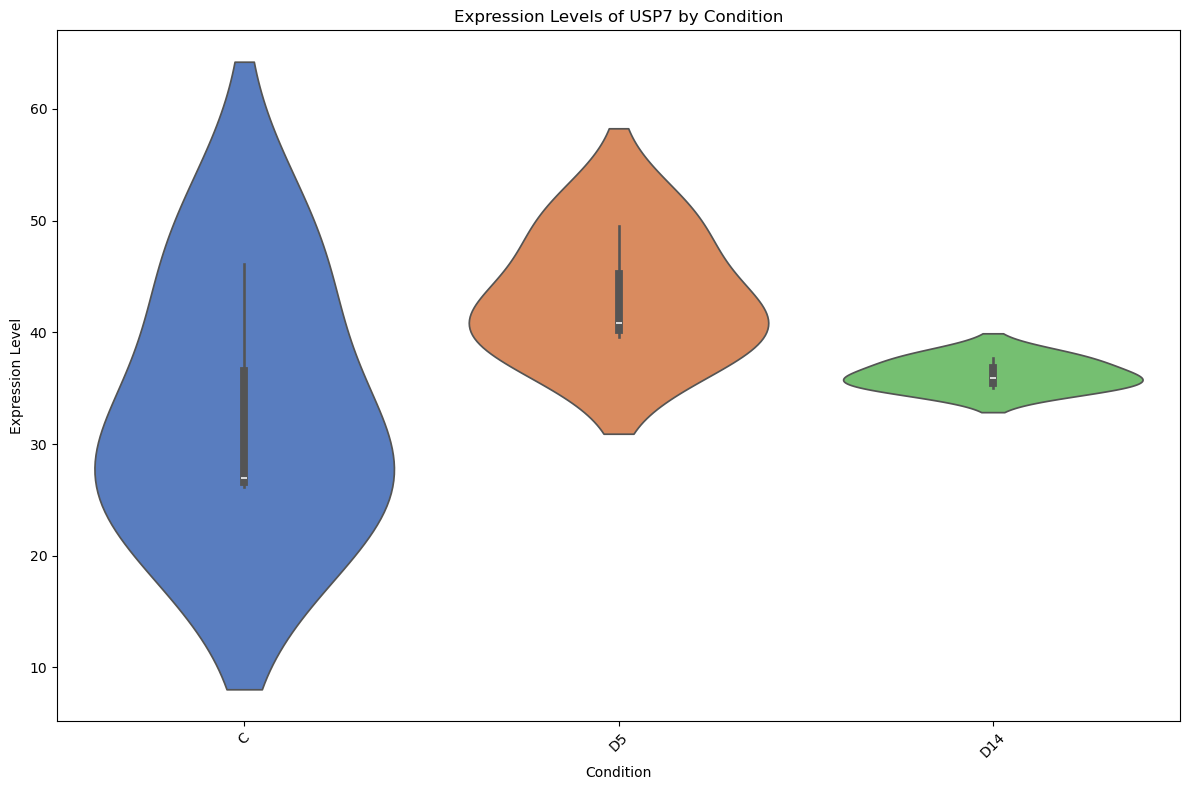

In [110]:
single_gene_sel = 'USP7'

single_gene_df = prepare_df_for_gene_violin(df, single_gene_sel)
print(single_gene_df)

plot_gene_violin(single_gene_df, single_gene_sel)